<a href="https://colab.research.google.com/github/Dan-Burns/Seq2Ensemble/blob/main/ColabOpenAWSEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup the software

In [1]:
#@title Run this cell to set working environment
!pip install -q condacolab
import condacolab
condacolab.install()

import warnings
warnings.filterwarnings("ignore")

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [1]:
#@title Run this cell to install required software (OpenMM, OpenAWSEM, Stride, BLAST ...)
%%capture
%%shell
#1. Install OpenMM and core dependencies
conda install -c conda-forge openmm pdbfixer mdtraj biopython py3dmol numpy pandas matplotlib

#2. Download openawsem
git clone https://github.com/PotoyanGroup/openawsem

#3. Download pdb_seqres
wget ftp://ftp.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt
mv pdb_seqres.txt openawsem/

#4. Download and isntall stride
wget http://webclu.bio.wzw.tum.de/stride/stride.tar.gz
mkdir stride_loc && tar -xf stride.tar.gz -C ./stride_loc
cd stride_loc && make

#5. Download and isntall BLAST (needed only for multi-fragment simulations)
#wget https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.13.0+-src.tar.gz
#mkdir blast_loc && tar  -xf ncbi-blast-2.13.0+-src.tar.gz
#cd ncbi-blast-2.13.0+-src.tar.gz && ./configure
#cd ncbi-blast-2.13.0+-src.tar.gz && make


### Create Project and Run simulation

Upload a PDB file of protein which can be obtained either via AlphaFold or from PDB database. 

In [2]:
#@title Upload a PDB file
from google.colab import files
import os

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  os.rename(fn, 'input.pdb')

# Create project 

Saving eicfull_b4a89_unrelaxed_rank_4_model_1.pdb to eicfull_b4a89_unrelaxed_rank_4_model_1.pdb
User uploaded file "eicfull_b4a89_unrelaxed_rank_4_model_1.pdb" with length 720171 bytes


In [3]:
#@title Run a constant temperature Molecular Dynamics with the [AWSEM](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008308) coarse-grained force-field for proteins 
Temperature = 250.0 #@param {type:"number"}
Timesteps   = 100000 #@param {type:"number"}

!export OPENAWSEM_LOCATION=/content/openawsem/ && PATH={$PATH}:/content/stride_loc && python3 /content/openawsem/mm_create_project.py input.pdb
!cp input-openmmawsem.pdb template.pdb
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 ./openawsem/helperFunctions/convertOpenmmTrajectoryToStandardMovie.py template.pdb
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 mm_run.py input  --steps $Timesteps --tempStart $Temperature --tempEnd $Temperature -f forces_setup.py

#@markdown ---
#@markdown > Lu, Wei, et al. "OpenAWSEM with Open3SPN2: A fast, flexible, and accessible framework for large-scale coarse-grained biomolecular simulations." <em>PLoS computational biology 17.2 (2021): e1008308 </em>

input
[<Chain 0>, <Chain 1>]
Chains: BC
Chains info read from crystal_structure.pdb, chains to simulate:  BC
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
protein: input, length: 1146
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning

## Analysis and visualization



In [4]:
#@markdown ### Install libraries for analysis and visualization

%%capture
!pip install MDAnalysis
!git clone https://github.com/Dan-Burns/molecular_dynamics_analysis_tools.git
!pip install paramagpy
from molecular_dynamics_analysis_tools.rdcs import *

from molecular_dynamics_analysis_tools.useful_functions import identical_subunits

import py3Dmol
from sklearn.decomposition import PCA
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

In [ ]:
#@markdown ### Load trajectory and visualize a sample of conformations

class Atom(dict):
    def __init__(self, line):
        self["type"] = line[0:6].strip()
        self["idx"] = line[6:11].strip()
        self["name"] = line[12:16].strip()
        self["resname"] = line[17:20].strip()
        self["resid"] = int(int(line[22:26]))
        self["x"] = float(line[30:38])
        self["y"] = float(line[38:46])
        self["z"] = float(line[46:54])
        self["sym"] = line[76:78].strip()

    def __str__(self):
        line = list(" " * 80)

        line[0:6] = self["type"].ljust(6)
        line[6:11] = self["idx"].ljust(5)
        line[12:16] = self["name"].ljust(4)
        line[17:20] = self["resname"].ljust(3)
        line[22:26] = str(self["resid"]).ljust(4)
        line[30:38] = str(self["x"]).rjust(8)
        line[38:46] = str(self["y"]).rjust(8)
        line[46:54] = str(self["z"]).rjust(8)
        line[76:78] = self["sym"].rjust(2)
        return "".join(line) + "\n"

class Molecule(list):
    def __init__(self, file):
        for line in file:
            if "ATOM" in line or "HETATM" in line:
                self.append(Atom(line))

    def __str__(self):
        outstr = ""
        for at in self:
            outstr += str(at)

        return outstr

### Create mdtraj trajectory for analysis
traj = md.load('movie.dcd', top='native.pdb')
traj =  traj.superpose(reference=traj)

### Split into snaps and load into movie
molecules = []
for i in np.linspace(0, traj.n_frames-1, 100):
  traj[int(i)].save(f'snap_{int(i)}.pdb')
  with open(f'snap_{int(i)}.pdb') as ifile:
        molecules.append(Molecule(ifile))

### Load each model into a movie
view = py3Dmol.view(width=400, height=300)

models = ""
for i, mol in enumerate(molecules):
    models += "MODEL " + str(i) + "\n"
    models += str(mol)
    models += "ENDMDL\n"
view.addModelsAsFrames(models)

for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

view.zoomTo()
view.animate({'loop': "forward"})
view.show()

KeyboardInterrupt: ignored

In [ ]:
#@title Perform PCA on cartesian positions of protein backbone

def get_pca(data, n_pcs=10):

    pca  = PCA(n_components=n_pcs)

    proj = pca.fit_transform(data)

    ll = pca.explained_variance_

    V = pca.components_
    
    return ll, V, proj


def eig_map(V, ctmap, k=0):
    '''Reshape eigenvector V into contact map of shape ctmap
    ---
    k: eigenvector index
    V: eigenvectors
    ctmap: contact map
    ---
    returns: eigenvector map
    '''
  
    return V[k,:].reshape(ctmap.shape)


sel_ca   = traj.topology.select('name CA')
pos = traj.xyz[:, sel_ca, :] #time, atoms, 3
pos_data = pos.reshape(traj.n_frames, -1)

ll, V, proj = get_pca(pos_data)

#print('Origina data shape', 'Reduced data shape')
df = pd.DataFrame(proj, columns=[f'PC{i+1}' for i in range(10)])
df['Steps'] = df.index

fig = px.scatter_matrix(df,
        dimensions=["PC1", "PC2", "PC3"],
        color="Steps" 
        )
  
fig.update_traces(diagonal_visible=False)
fig.show()

/usr/local/lib/python3.9/dist-packages/plotly/express/_core.py:279: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  dims = [


In [5]:
#@title Cluster the Trajectory
### TODO ####
## Silence errors
%%capture

#@markdown ## Perform RMSD clustering
from Bio.PDB import PDBParser
import MDAnalysis.analysis.encore as encore
import MDAnalysis as mda

#@markdown Set maximum number of clusters to generate.
#@markdown Trajectory will be clustered seperately into n=1 to n clusters.
#@markdown Subsequent RDC fitting will reveal the optimal ensemble size.
n_clusters = 5 #@param {type:"number"}

pdb   = 'template.pdb'
model = PDBParser().get_structure('structure',pdb)

# hold chain IDs and residue object lists
# use to compare the subunits and figure out if they're identical or not
chains = {chain.id: chain.get_unpacked_list() for chain in model.get_chains()}

trajectory = 'movie.dcd'
structure = 'template.pdb'
u = mda.Universe(structure, trajectory)

#############################
# if it's a homo-multimer, separate the subunits and concatenate into
# a long single-subunit trajectory for clustering
# Otherwise deal with the trajectory and one or more subunits in its original form
if identical_subunits(chains) == True: 
  # make a dictionary of chain/subunit keys with atom selection values
  selections = {}
  for chain in chains.keys():
    selections[chain] = u.select_atoms('segid '+chain)

  # make a directory to hold the seperated subunits
  out_dir = 'seperated_trajectories/'
  if not os.path.exists(out_dir):
      os.makedirs(out_dir)
  # clean the directory if it already exists
  for f in os.listdir(out_dir):
      os.remove(out_dir+f)

  # Instead of writing the seperated trajectories to files, 
  # can probably use u.merge() - but people might want to download trajectories...
  for chain, selection in selections.items():
      with mda.Writer(f'{out_dir}chain_{chain}.dcd', selection.n_atoms) as W:
          for ts in u.trajectory:
              W.write(selection)
  # write one subunit to a pdb
  # can probably just use the selection instead of a saved pdb
  # assuming we're just working with EI dimer for this
  selections[list(selections.keys())[0]].write('one_subunit.pdb')
 
  # align the seperated subunit trajectory
  from MDAnalysis.analysis import align
  # conatenate
  seperated_trajs = [out_dir+traj for traj in os.listdir(out_dir) if traj.endswith('dcd')]
  pdb = 'one_subunit.pdb'
  ref = mda.Universe(pdb)
  sep_u = mda.Universe(pdb, seperated_trajs)
  aligned_traj_name = 'aligned_seperated_subunits.dcd'
  align.AlignTraj(sep_u, ref,select='name CA',filename=aligned_traj_name).run()


else: ## just align the original trajectory for clustering 
  from MDAnalysis.analysis import align
  aligned_traj_name = 'aligned_traj.dcd'
  ref = mda.Universe(pdb)
  align.AlignTraj(u, ref, select='name CA',filename=aligned_traj_name).run()

for cluster_iteration in range(n_clusters):
    structure = pdb
    trajectory = aligned_traj_name
    u = mda.Universe(structure, trajectory)
    # add n_jobs argument so that all n_init are run in parallel (default is 10)
    ensemble = encore.cluster(u, method=encore.clustering.ClusteringMethod.KMeans(n_clusters=cluster_iteration+1))
    #####################################
    # change this selection from 'name CA' to 'protein' when using structure file with 
    # correct residue names
    #####################################
    selection = u.select_atoms('protein')
    ######################################
    clusters = []
    for i, cluster in enumerate(ensemble.clusters):
        u.trajectory[cluster.centroid]
        if not os.path.exists(f'cluster_{cluster_iteration+1}/'):
          os.makedirs(f'cluster_{cluster_iteration+1}/')
        selection.write(f'cluster_{cluster_iteration+1}/centroid_{i+1}.pdb')
        clusters.append(int(cluster.centroid))


In [6]:
#@title Upload a RDC data

from google.colab import files
uploaded_rdcs = files.upload()

for fn in uploaded_rdcs.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_rdcs[fn])))
  os.rename(fn, 'rdcs.dat')

Saving sparky_Dnh_70.dat to sparky_Dnh_70.dat
User uploaded file "sparky_Dnh_70.dat" with length 9807 bytes


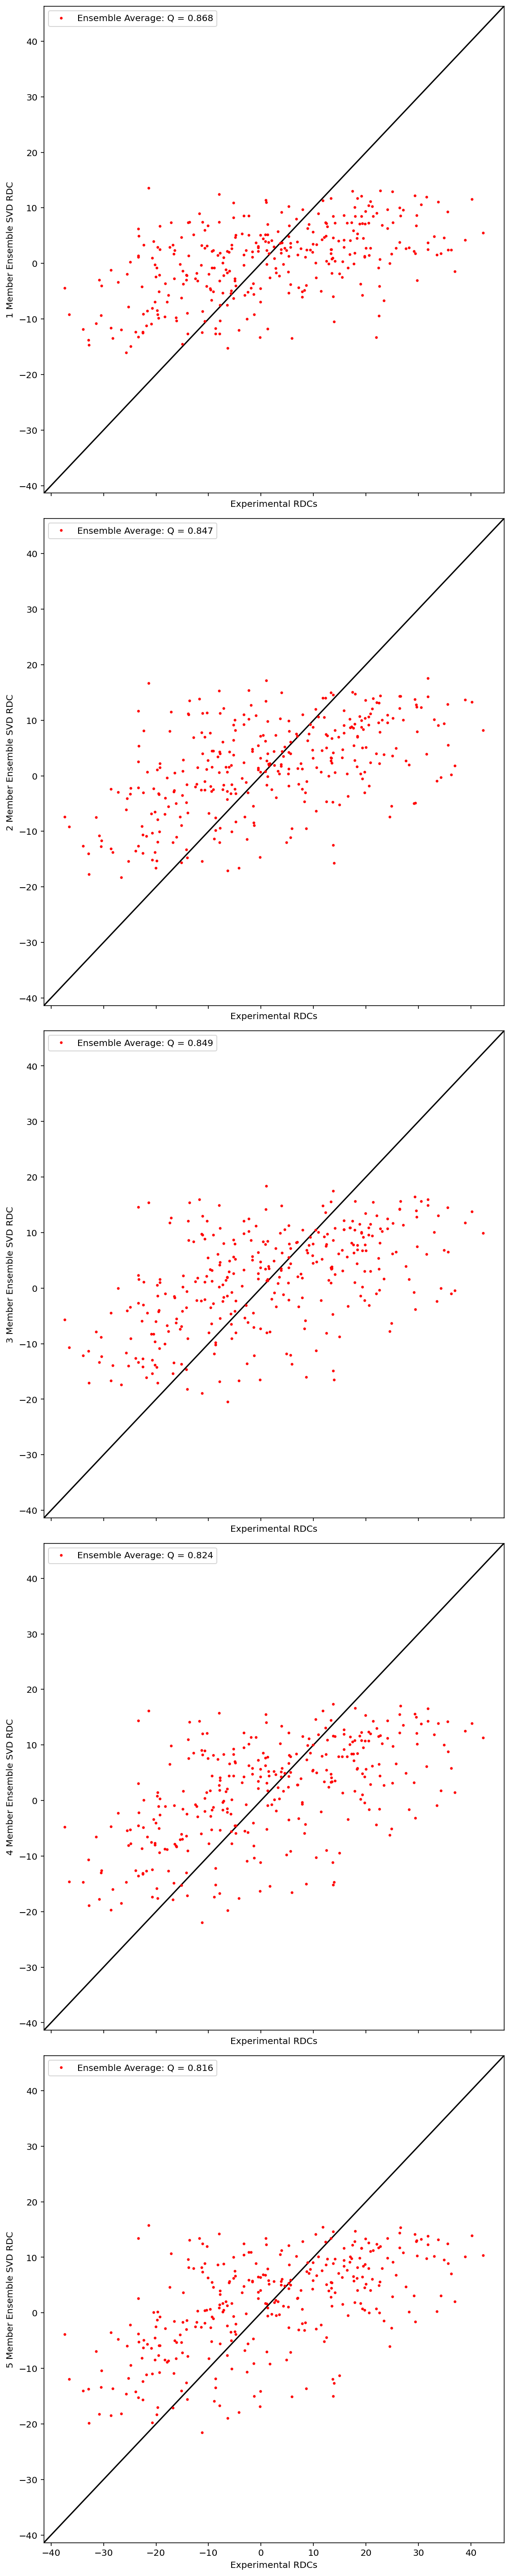

In [7]:
#@title Fit Cluster Ensembles to RDC data

%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

rdc_file = 'rdcs.dat'
# check the rdc file format
rdc_file_format = determine_rdc_file_format(rdc_file)
format_rdc_file(rdc_file, rdc_file_format, 'formatted_rdcs.dat')

# set up directories for saving the SVD fitting results
rdc_plots = 'svd_rdc_fitting_plots'
calculated_rdcs = 'svd_calculated_rdcs'
if os.path.exists(rdc_plots):
  pass
else:
  os.makedirs(rdc_plots)
if os.path.exists(calculated_rdcs):
  pass
else:
  os.makedirs(calculated_rdcs)
# store the multi-pdb files made from the different centroid sets in a seperate directory
if os.path.exists('cluster_ensemble_pdbs'):
  pass
else:
  os.makedirs('cluster_ensemble_pdbs')

# make a list of the folders that contain the cluster iteration centroids
# will have to change the list comprehension if we add option to do specific cluster iterations
cluster_folders = [f'cluster_{i+1}' for i in range(n_clusters)]
# specify magnet strength in T
#@markdown Specify magnetic field strength in T.
magnetic_field = 18.0 #@param {type:"number"}
#@markdown Specify temperature of aligned sample in K.
# Can we get the variable from the simulation to populate the input here?
Temperature = 300.00 #@param (type:"number")


# set up subplots 
fig, axs = plt.subplots(n_clusters,1,
                        sharex=True,sharey=True,
                        figsize=(8,n_clusters*8))
# do all the fits and plots in a loop
for i in range(n_clusters):



  tensor = metal.Metal(B0=magnetic_field, temperature=Temperature)
  cluster_folder = cluster_folders[i]


  # make a multi-pdb file
  ensemble_pdb = f'cluster_ensemble_pdbs/{i+1}_centroids_ensemble.pdb'
  centroids = [f'{cluster_folder}/{pdb_file}' for pdb_file in os.listdir(cluster_folder)]
  make_multi_pdb_file(ensemble_pdb, centroids)

  # make paramagpy pdb/rdc object
  prot = protein.load_pdb(ensemble_pdb)
  rdc_prot = prot.parse(dataparse.read_rdc('formatted_rdcs.dat'))

  # SVD Fit
  [solution], [data] = fit.svd_fit_metal_from_rdc([tensor],
                                                  [rdc_prot],
                                                  ensembleAverage=True
                                                  )

  qfactor = fit.qfactor(data, ensembleAverage=True)

  # ensemble average RDC
  EA = fit.ensemble_average(data)
  # convert to dataframe to save CSV for download of residue numbers and calculated RDC
  df = pd.DataFrame({'resids':[atom.full_id[3][1] for atom in EA['atm']], 'RDCs':EA['cal']})
  df.to_csv(f'{calculated_rdcs}/{i+1}_member_ensemble_rdcs.csv')
  # save qfactor to text file
  with open(f"{calculated_rdcs}/{i+1}_member_ensemble_q_factor.txt",'w') as f:
    f.write(str(qfactor))


  # plot
  axs.flat[i].plot(EA['exp'], EA['cal'], marker='o', lw=0, ms=2, c='r',
          label=f'Ensemble Average: Q = {round(qfactor,3)}')

  # plot the diagonal
  l, h = axs.flat[i].get_xlim()
  axs.flat[i].plot([l,h],[l,h],'-k', zorder=0, ms=2)
  axs.flat[i].set_xlim(l,h)
  axs.flat[i].set_ylim(l,h)

  # labels
  axs.flat[i].set_xlabel("Experimental RDCs")
  axs.flat[i].set_ylabel(f"{i+1} Member Ensemble SVD RDC")
  axs.flat[i].legend()
fig.tight_layout()
fig.savefig(f'{rdc_plots}/ensemble_rdc_fits.pdf')


In [8]:
# Download the BME repository
!git clone https://github.com/KULL-Centre/BME.git

Cloning into 'BME'...
remote: Enumerating objects: 478, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 478 (delta 36), reused 90 (delta 35), pack-reused 385
Receiving objects: 100% (478/478), 111.83 MiB | 29.10 MiB/s, done.
Resolving deltas: 100% (256/256), done.


In [9]:
#@title Fit RDCs for each frame and write to file
u = mda.Universe(pdb, aligned_traj_name)
u.trajectory[0]
with open('test_calculated_rdcs.dat','w') as f:

  for i,frame in enumerate(u.trajectory):
    selection = u.select_atoms('protein')
    selection.write(f'frame_{i}.pdb')
    prot = protein.load_pdb(f'frame_{i}.pdb')
    rdc_prot = prot.parse(dataparse.read_rdc('formatted_rdcs.dat'))

    # SVD Fit
    [solution], [data] = fit.svd_fit_metal_from_rdc([tensor],
                                                    [rdc_prot],
                                                    ensembleAverage=True
                                                    )

    if i != 0:
      f.write('\n')
    f.write(f'frame_{i}.pdb ')
    for rdc_val in data['cal']:
      f.write(f'{rdc_val} ')
    os.remove(f'frame_{i}.pdb')

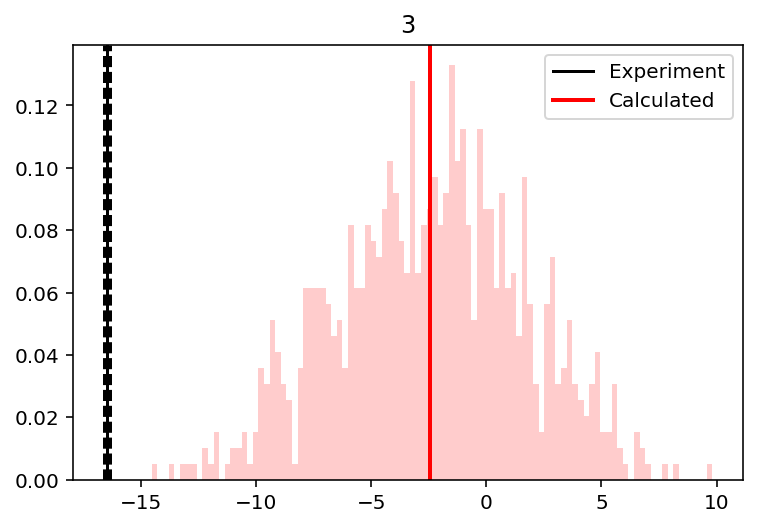

In [10]:
#@title Average Calculated and Experimental RDC Value
# load experimental datafile
### if using sparky format with error, use cols 1, and 2
### if using matlab format usecols 1 and uncomment the 2 lines below
exp = np.loadtxt("rdcs.dat",usecols=(1,2))
# add an error column since there's none in the example rdc file ###########
#a = np.ones((1,len(exp)))
#exp = np.concatenate(([exp],a),axis=0).T
#######
labels = np.loadtxt("rdcs.dat",usecols=(0),dtype=str)

calcs = np.loadtxt("test_calculated_rdcs.dat",dtype=str)
# This broke - calcs got double the number of columns it's supposed to have
calcs = pd.DataFrame(calcs[:,1:].astype(float),columns=labels)
calc = calcs.to_numpy()
i=1
# plot experimental average and error
_ = plt.axvline(exp[i-1,0],c='k',label="Experiment")
_ = plt.axvline(exp[i-1,0]-exp[i-1,1],c='k',linestyle="--")
_ = plt.axvline(exp[i-1,0]+exp[i-1,1],c='k',linestyle="--")

# Plot calculated average
average = np.average(calc[:,i])
_ = plt.axvline(average,c='r',label="Calculated",lw=2)

# plot histogram of the data
_ = plt.hist(calc[:,i],bins=100,density=True,alpha=0.2,color='r')
plt.title(labels[i-1])

plt.legend()

In [11]:
print(f'Calculated rdcs for {calc.shape[0]} frames')

Calculated rdcs for 804 frames


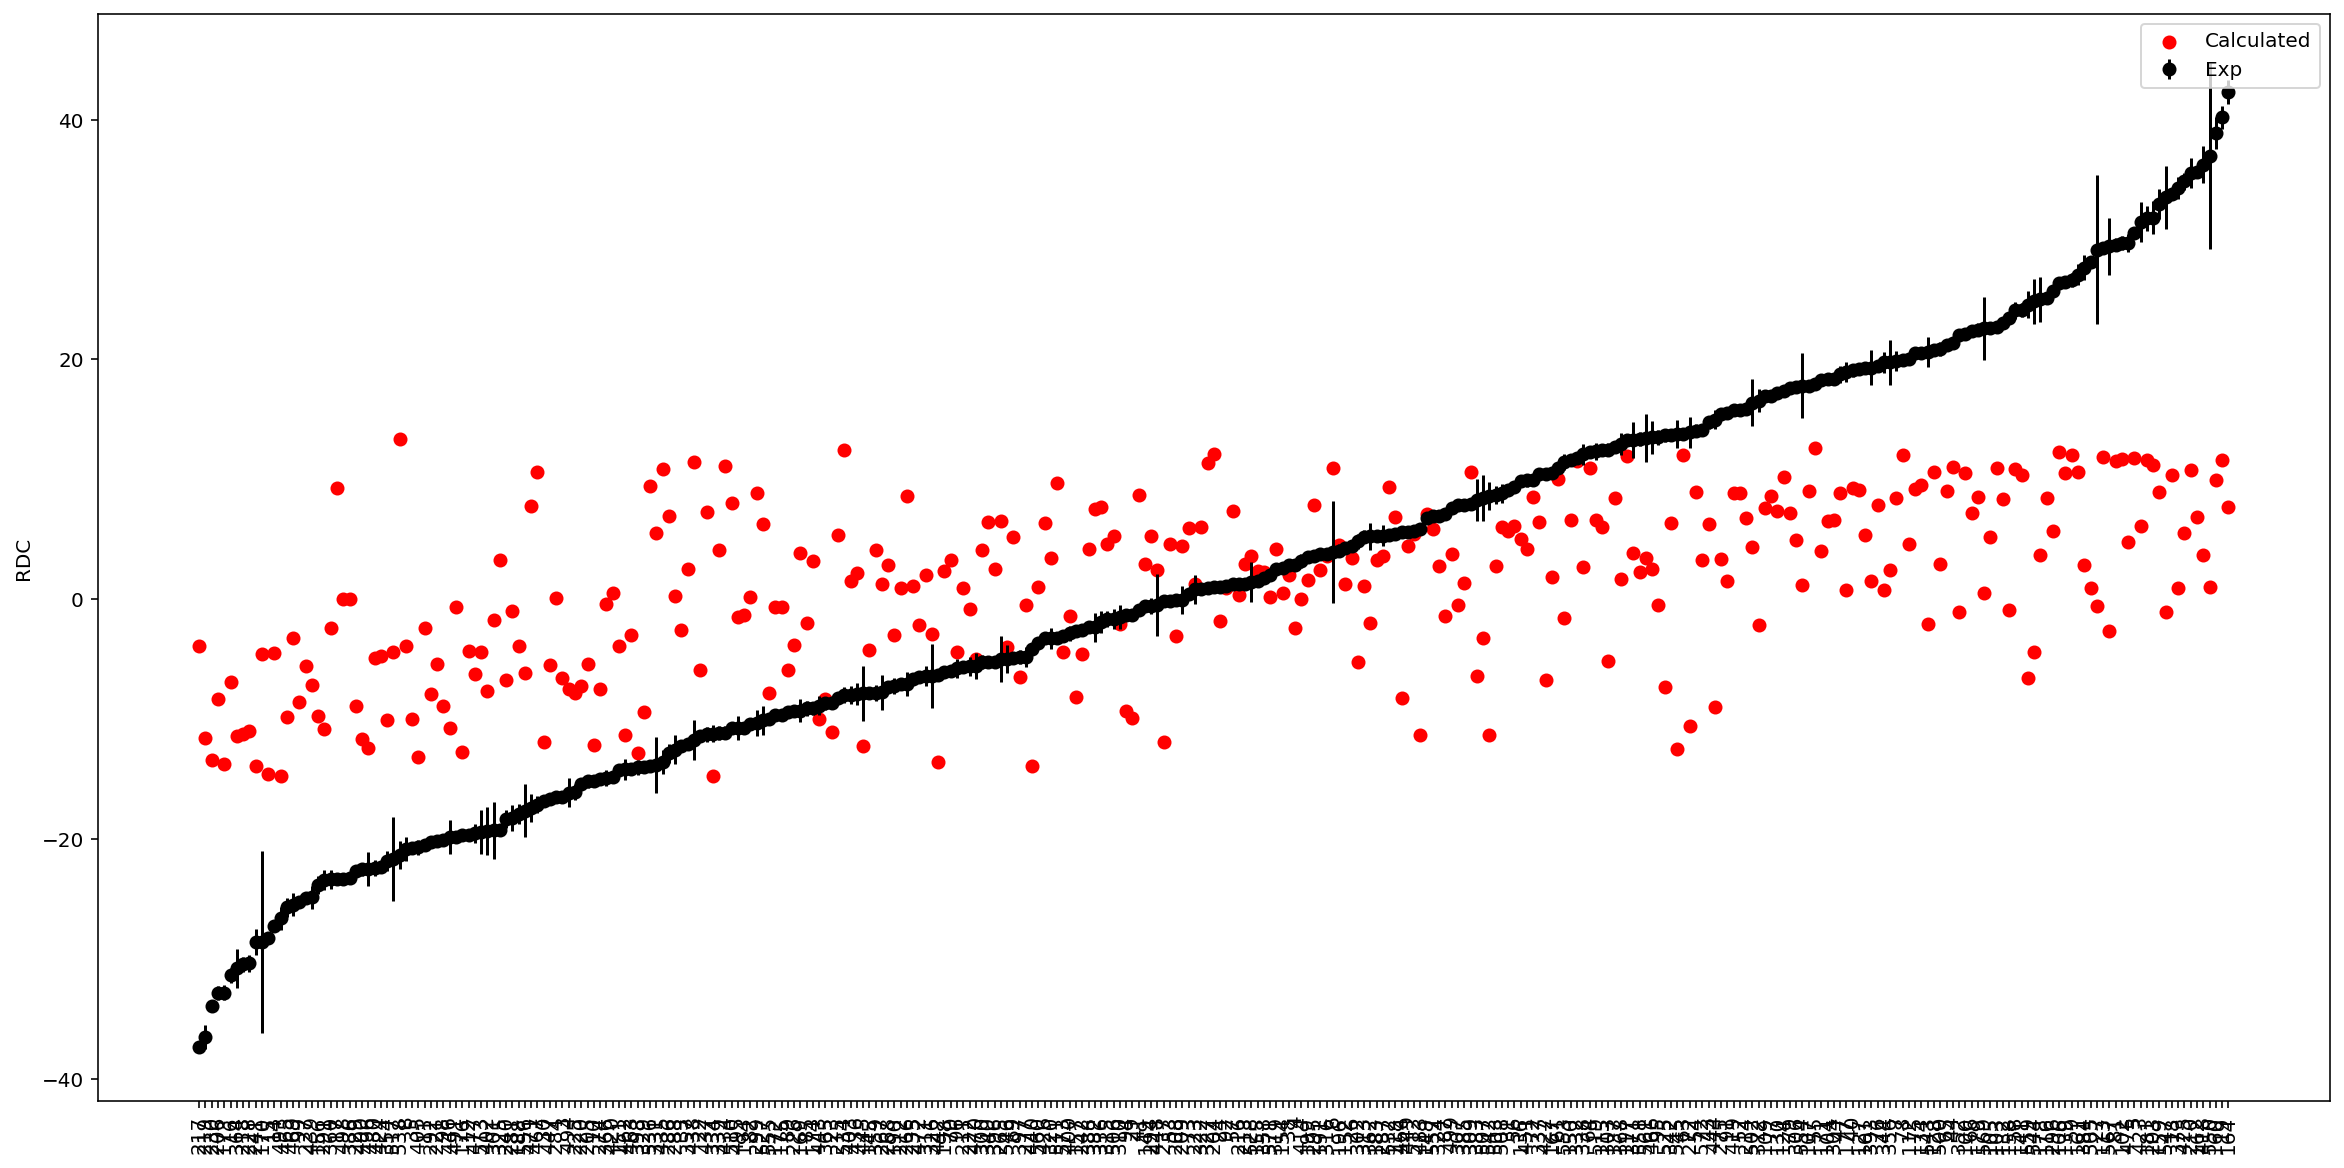

In [12]:
#@title Calculated and Experimental RDCs
# below line was in original BME notebook, probably to skip the pdb id column
# changed to use all columns since they're all rdc values in this version
#averages = np.average(calc[:,1:],axis=0)
averages = np.average(calc[:,:],axis=0)
idx_ordered = np.argsort(exp[:,0])

fig, ax = plt.subplots(figsize=(20, 10))

xx = range(len(labels))
plt.errorbar(xx, exp[idx_ordered,0],exp[idx_ordered,1],c='k',fmt="o",label="Exp")
plt.scatter(xx,averages[idx_ordered],c='r',label="Calculated")
plt.legend()
plt.ylabel("RDC")
_ = plt.xticks(xx,[labels[l] for l in idx_ordered],rotation=90)


In [13]:
# format rdc file for BME
with open('bme_rdcs.dat','w') as f:
  f.write('# DATA=RDC \n')
  with open('rdcs.dat','r') as g:
    for line in g.readlines():
      # Adding in error #### DON'T ADD IF ERROR IS ALREADY IN FILE
      #f.write(f'{line[:-1]}  1 \n') # uncomment if using matlab format and comment out following 2 lines
      resid, rdc_val, error, _, _ = re.split(r'\s+',line)
      f.write(f'{resid} {rdc_val} {error}\n')

In [14]:
#Show reformatted RDC file
!cat bme_rdcs.dat | head

# DATA=RDC 
3 -16.491 1.28741e-01
4 2.848 1.65540e-01
5 30.5491 5.14992e-01
6 3.9067 4.26182e+00
7 19.8488 8.16399e-01
8 -20.859 9.83087e-01
10 -15.148 3.77134e-01
11 -20.512 2.09857e-01
12 -19.688 3.87464e-01


In [15]:
# run once 
sys.path.append('BME')

In [17]:
import sys,os
#@markdown Set theta 
theta = 100 #@param {type:"number"}

# This import is different from example - having trouble reliably importing BME
import BME as BME
exp_file = "bme_rdcs.dat"
calc_file = "test_calculated_rdcs.dat"

# initialize. A name must be specified 
rew = BME.Reweight("example_01")

# load the experimental and calculated datasets
rew.load(exp_file,calc_file)

# fit the data 
chi2_before, chi2_after, phi = rew.fit(theta=theta)

# print statistics
print("Chi2 before BME %.2f" % chi2_before)
print("Chi2 after  BME %.2f" % chi2_after)
print("Fraction of effective frames %.2f" % phi)

Chi2 before BME 944.51
Chi2 after  BME 711.67
Fraction of effective frames 0.01


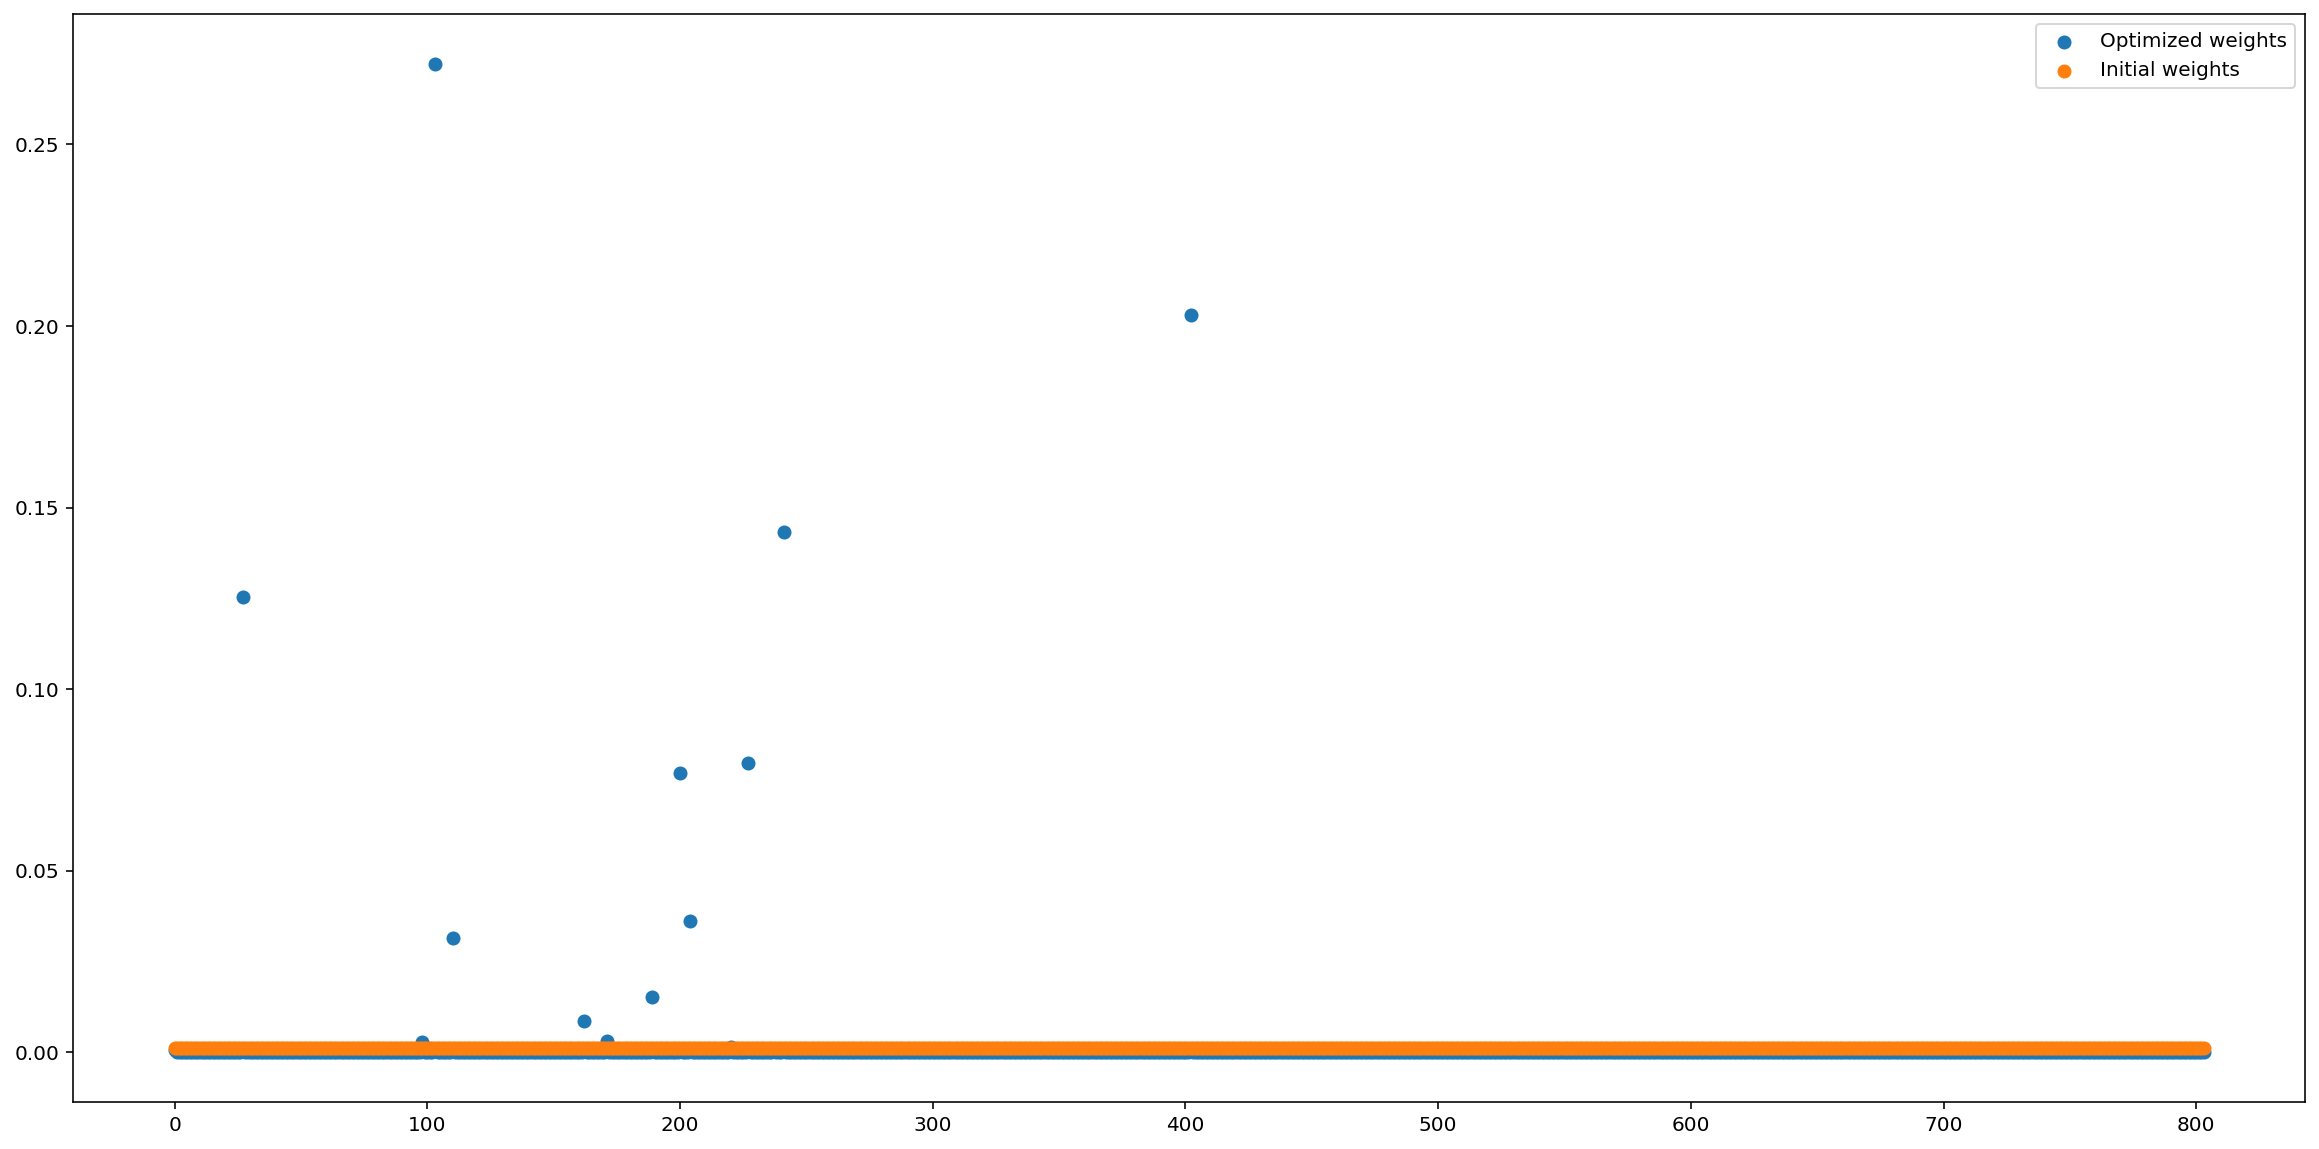

In [18]:
#@title Show the BME Weights for the Trajectory Frames
fig, ax = plt.subplots(figsize=(20, 10))
w0 = rew.get_w0()
w_new = rew.get_weights()

plt.scatter(range(len(w0)),w_new,label="Optimized weights")
plt.scatter(range(len(w0)),w0,label="Initial weights")
#plt.ylim(0,0.015)
plt.legend()
plt.show()
plt.close()

In [19]:
#@title Get highest weighted conformations

#@markdown Set maximum number of clusters to generate.
#@markdown Trajectory will be clustered seperately into n=1 to n clusters.
#@markdown Subsequent RDC fitting will reveal the optimal ensemble size.
n_clusters = 10 #@param {type:"number"}
for conformations in range(1,n_clusters+1):
  if os.path.exists(f'bme_clusters_{conformations}'):
      pass
  else:
    os.makedirs(f'bme_clusters_{conformations}')
  for frame in (-w_new).argsort()[:conformations]:
    u.trajectory[frame]
    selection = u.select_atoms('protein')
    selection.write(f'bme_clusters_{conformations}/frame_{frame}.pdb')


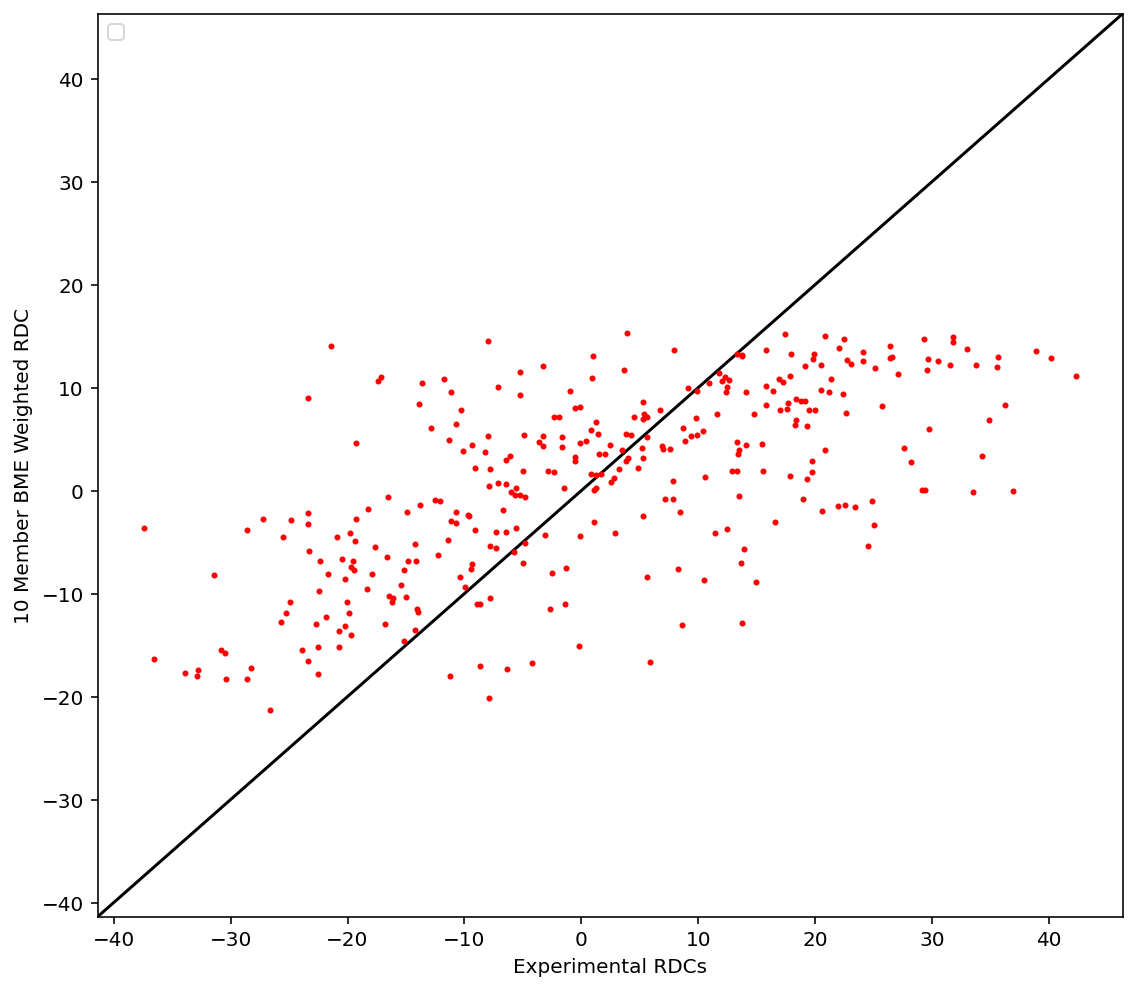

In [69]:
# open the rdc-per-frame file and pull out the rdc records for the highest weighted frames
calcs = np.loadtxt("test_calculated_rdcs.dat",dtype=str)
calcs = pd.DataFrame(calcs[:,1:].astype(float),columns=labels)
# multiply the n conformations rdc values by the BME weight of the corresponding conformation
weighted_rdcs = calcs.iloc[(-w_new).argsort()[:conformations]].T*(w_new[(-w_new).argsort()[:conformations]])
# Sum all of these RDCs
weighted_sum = weighted_rdcs.sum(axis=1)
# plot
fig, ax = plt.subplots(figsize=(8,7))
ax.plot(exp[:,0], weighted_sum, marker='o', lw=0, ms=2, c='r',
        )

# plot the diagonal
l, h = axs.flat[i].get_xlim()
ax.plot([l,h],[l,h],'-k', zorder=0, ms=2)
ax.set_xlim(l,h)
ax.set_ylim(l,h)

# labels
ax.set_xlabel("Experimental RDCs")
ax.set_ylabel(f"{conformations} Member BME Weighted RDC")
ax.legend()
fig.tight_layout()



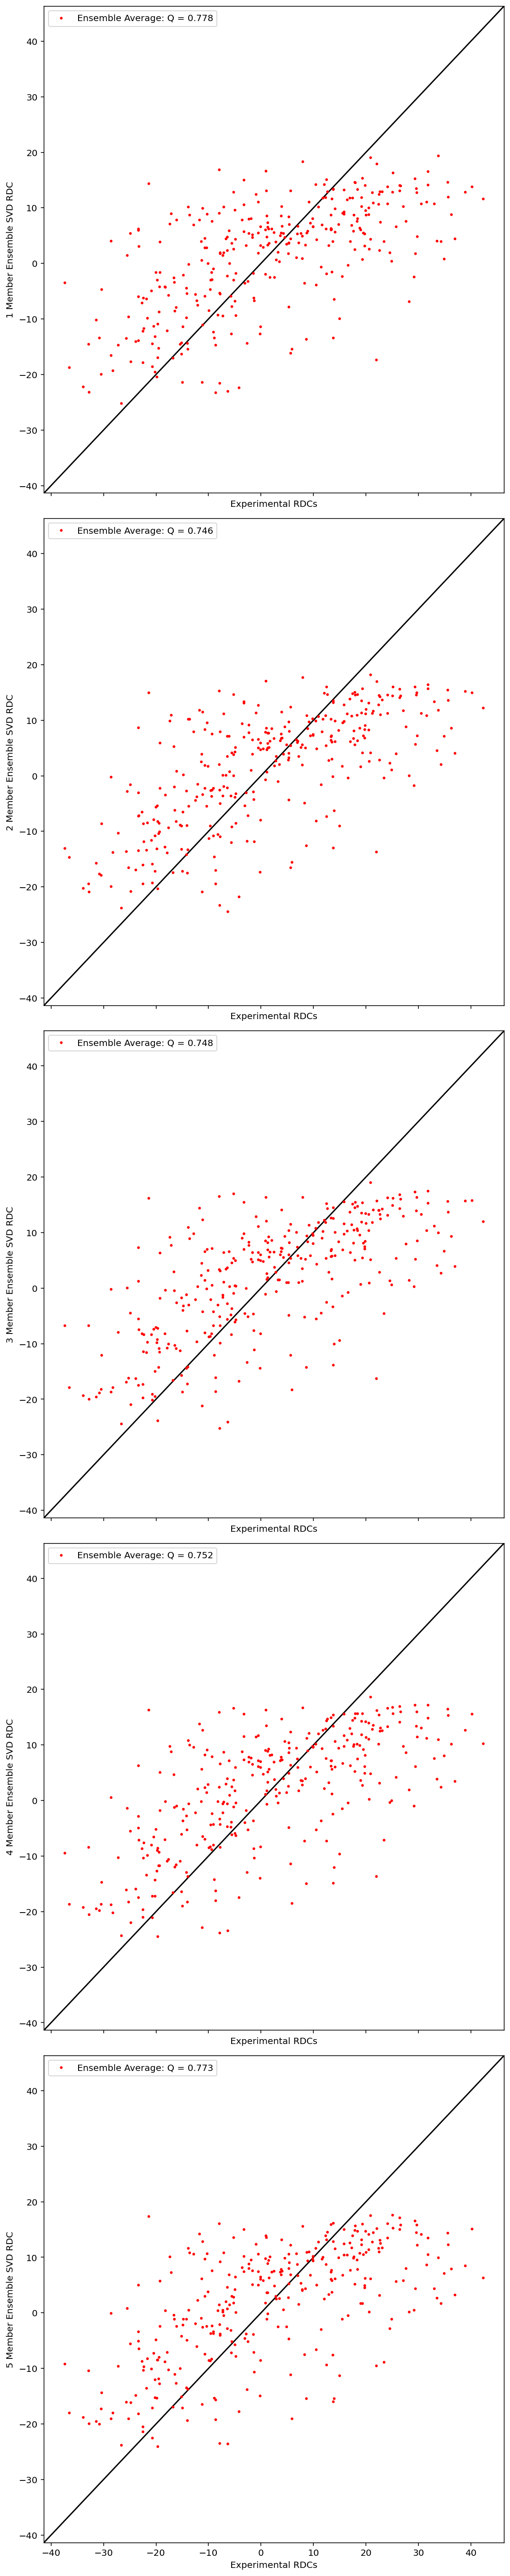

In [ ]:
#@title Fit High BME Weight Structures to RDC data

%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

rdc_file = 'rdcs.dat'
# check the rdc file format
rdc_file_format = determine_rdc_file_format(rdc_file)
format_rdc_file(rdc_file, rdc_file_format, 'formatted_rdcs.dat')

# set up directories for saving the SVD fitting results
rdc_plots = 'bme_svd_rdc_fitting_plots'
calculated_rdcs = 'bme_svd_calculated_rdcs'
if os.path.exists(rdc_plots):
  pass
else:
  os.makedirs(rdc_plots)
if os.path.exists(calculated_rdcs):
  pass
else:
  os.makedirs(calculated_rdcs)
# store the multi-pdb files made from the different centroid sets in a seperate directory
if os.path.exists('bme_cluster_ensemble_pdbs'):
  pass
else:
  os.makedirs('bme_cluster_ensemble_pdbs')

# make a list of the folders that contain the cluster iteration centroids
# will have to change the list comprehension if we add option to do specific cluster iterations
cluster_folders = [f'bme_clusters_{i+1}' for i in range(n_clusters)]
# specify magnet strength in T
#@markdown Specify magnetic field strength in T.
magnetic_field = 18.0 #@param {type:"number"}
#@markdown Specify temperature of aligned sample in K.
# Can we get the variable from the simulation to populate the input here?
Temperature = 300.00 #@param (type:"number")


# set up subplots 
fig, axs = plt.subplots(n_clusters,1,
                        sharex=True,sharey=True,
                        figsize=(8,n_clusters*8))
# do all the fits and plots in a loop
for i in range(n_clusters):



  tensor = metal.Metal(B0=magnetic_field, temperature=Temperature)
  cluster_folder = cluster_folders[i]


  # make a multi-pdb file
  ensemble_pdb = f'bme_cluster_ensemble_pdbs/{i+1}_centroids_ensemble.pdb'
  centroids = [f'{cluster_folder}/{pdb_file}' for pdb_file in os.listdir(cluster_folder)]
  make_multi_pdb_file(ensemble_pdb, centroids)

  # make paramagpy pdb/rdc object
  prot = protein.load_pdb(ensemble_pdb)
  rdc_prot = prot.parse(dataparse.read_rdc('formatted_rdcs.dat'))

  # SVD Fit
  [solution], [data] = fit.svd_fit_metal_from_rdc([tensor],
                                                  [rdc_prot],
                                                  ensembleAverage=True
                                                  )

  qfactor = fit.qfactor(data, ensembleAverage=True)

  # ensemble average RDC
  EA = fit.ensemble_average(data)
  # convert to dataframe to save CSV for download of residue numbers and calculated RDC
  df = pd.DataFrame({'resids':[atom.full_id[3][1] for atom in EA['atm']], 'RDCs':EA['cal']})
  df.to_csv(f'{calculated_rdcs}/{i+1}_member_ensemble_rdcs.csv')
  # save qfactor to text file
  with open(f"{calculated_rdcs}/{i+1}_member_ensemble_q_factor.txt",'w') as f:
    f.write(str(qfactor))


  # plot
  axs.flat[i].plot(EA['exp'], EA['cal'], marker='o', lw=0, ms=2, c='r',
          label=f'Ensemble Average: Q = {round(qfactor,3)}')

  # plot the diagonal
  l, h = axs.flat[i].get_xlim()
  axs.flat[i].plot([l,h],[l,h],'-k', zorder=0, ms=2)
  axs.flat[i].set_xlim(l,h)
  axs.flat[i].set_ylim(l,h)

  # labels
  axs.flat[i].set_xlabel("Experimental RDCs")
  axs.flat[i].set_ylabel(f"{i+1} Member Ensemble SVD RDC")
  axs.flat[i].legend()
fig.tight_layout()
fig.savefig(f'{rdc_plots}/ensemble_rdc_fits.pdf')

In [ ]:
#@title Package and download clustering results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `Clustering_output.zip`, right-click and select \"Download\".

%%capture
!zip -FSr "Clustering_output.zip" cluster_*
files.download("Clustering_output.zip")

  adding: cluster_1/ (stored 0%)
  adding: cluster_1/centroid_1.pdb (deflated 77%)
  adding: cluster_10/ (stored 0%)
  adding: cluster_10/centroid_3.pdb (deflated 77%)
  adding: cluster_10/centroid_5.pdb (deflated 77%)
  adding: cluster_10/centroid_8.pdb (deflated 77%)
  adding: cluster_10/centroid_9.pdb (deflated 77%)
  adding: cluster_10/centroid_1.pdb (deflated 77%)
  adding: cluster_10/centroid_10.pdb (deflated 77%)
  adding: cluster_10/centroid_6.pdb (deflated 77%)
  adding: cluster_10/centroid_2.pdb (deflated 77%)
  adding: cluster_10/centroid_4.pdb (deflated 77%)
  adding: cluster_10/centroid_7.pdb (deflated 77%)
  adding: cluster_2/ (stored 0%)
  adding: cluster_2/centroid_1.pdb (deflated 77%)
  adding: cluster_2/centroid_2.pdb (deflated 77%)
  adding: cluster_3/ (stored 0%)
  adding: cluster_3/centroid_3.pdb (deflated 77%)
  adding: cluster_3/centroid_1.pdb (deflated 77%)
  adding: cluster_3/centroid_2.pdb (deflated 77%)
  adding: cluster_4/ (stored 0%)
  adding: cluster_4/cen

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>